### Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from IPython.display import HTML, display, SVG
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot

import math
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

import nltk
import string
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

/usr/lib/python3.5/importlib/_bootstrap_external.py:415: ImportWarning:

Not importing directory /home/abhishek/.local/lib/python3.5/site-packages/google: missing __init__

/usr/lib/python3.5/importlib/_bootstrap_external.py:415: ImportWarning:

Not importing directory /home/abhishek/.local/lib/python3.5/site-packages/mpl_toolkits: missing __init__

Using TensorFlow backend.
/home/abhishek/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:936: DeprecationWarning:

builtin type EagerTensor has no __module__ attribute

/home/abhishek/.local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/home/abhishek/.local/lib/python3.5/site-packages/tensorflow/python/keras/backend.py:4712: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/home/abhishek/.keras/keras.json' mode='r' encoding='UTF-8'>



In [2]:
seed = 13
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()

le = LabelEncoder()

In [3]:
SOURCE_FOLDER = 'dataset/'
OUTPUT_FOLDER = 'Models_and_output/'

In [4]:
train_data = pd.read_csv(SOURCE_FOLDER + 'train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv(SOURCE_FOLDER + 'test.csv', encoding='utf8')
test_data = test_data[test_data.columns[1:-1]]

In [5]:
train_data = train_data[train_data['TRANS_CONV_TEXT'].notnull()]

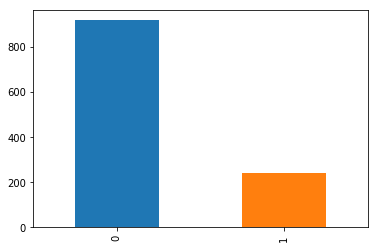

In [6]:
le.fit(train_data.Source)
train_source = le.transform(train_data.Source)

train_data.Patient_Tag.value_counts().plot('bar')

In [7]:
X_train = train_data['TRANS_CONV_TEXT']
Y_train = train_data['Patient_Tag']
Y_train = to_categorical(Y_train)

In [8]:
def preprocess_data(X_train, stemmer, lemma):
    preprocessed_data = []
    trans = str.maketrans('/(){}', ' ' * 5)
    trans_punc = str.maketrans('', '', string.punctuation)

    for text in X_train:
        text = text.lower().translate(trans)
        text = text.translate(trans_punc)
        text = [lemma.lemmatize(word) for word in text.split()]
        preprocessed_data.append(' '.join(text))

    return preprocessed_data

In [9]:
preprocessed_data = preprocess_data(X_train, stemmer, lemma)

In [10]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1, 3))
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [11]:
X_train = vectorizer.transform(X_train).toarray()
X_train.shape

(1156, 1000)

In [12]:
X_train = np.insert(X_train, 0, train_source, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.33, random_state=seed)

In [13]:
train_data.Source.head()

0    FORUMS
1    FORUMS
2      BLOG
3    FORUMS
4    FORUMS
Name: Source, dtype: object

In [18]:
X_train.shape

(774, 1001)

In [19]:
X_valid.shape

(382, 1001)

In [14]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [15]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

In [20]:
custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=1001))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2,
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.4)))

In [21]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

model.compile(optimizer=custom_adam,
              loss='categorical_crossentropy',
              metrics=[auc_pr, 'accuracy'])

model.fit_generator(generator=batch_generator_shuffle(X_train, y_train, 32),
                      epochs=200, validation_data=(X_valid, y_valid),
                      steps_per_epoch=X_train.shape[0] / 32)

scores = model.evaluate(X_valid, y_valid)
print ('\n')
print (scores)

Epoch 1/200
25/24 [===============================] - 1s 23ms/step - loss: 1.2544 - auc_pr: 0.7852 - acc: 0.7960 - val_loss: 0.7795 - val_auc_pr: 0.8899 - val_acc: 0.7906
Epoch 2/200
25/24 [===============================] - 0s 7ms/step - loss: 0.4765 - auc_pr: 0.9205 - acc: 0.8974 - val_loss: 0.4471 - val_auc_pr: 0.9348 - val_acc: 0.8586
Epoch 3/200
25/24 [===============================] - 0s 7ms/step - loss: 0.1829 - auc_pr: 0.9485 - acc: 0.9773 - val_loss: 0.6460 - val_auc_pr: 0.9543 - val_acc: 0.8403
Epoch 4/200
25/24 [===============================] - 0s 7ms/step - loss: 0.0773 - auc_pr: 0.9581 - acc: 0.9887 - val_loss: 0.4314 - val_auc_pr: 0.9631 - val_acc: 0.8665
Epoch 5/200
25/24 [===============================] - 0s 7ms/step - loss: 0.0338 - auc_pr: 0.9666 - acc: 0.9975 - val_loss: 0.4901 - val_auc_pr: 0.9690 - val_acc: 0.8560
Epoch 6/200
25/24 [===============================] - 0s 7ms/step - loss: 0.0223 - auc_pr: 0.9706 - acc: 0.9987 - val_loss: 0.5076 - val_auc_pr: 0.97

25/24 [===============================] - 0s 6ms/step - loss: 3.9212e-04 - auc_pr: 0.9823 - acc: 1.0000 - val_loss: 0.6970 - val_auc_pr: 0.9823 - val_acc: 0.8613
Epoch 48/200
25/24 [===============================] - 0s 6ms/step - loss: 5.1677e-04 - auc_pr: 0.9824 - acc: 1.0000 - val_loss: 1.3243 - val_auc_pr: 0.9822 - val_acc: 0.8298
Epoch 49/200
25/24 [===============================] - 0s 6ms/step - loss: 5.0137e-04 - auc_pr: 0.9821 - acc: 1.0000 - val_loss: 0.9288 - val_auc_pr: 0.9820 - val_acc: 0.8429
Epoch 50/200
25/24 [===============================] - 0s 6ms/step - loss: 4.2377e-04 - auc_pr: 0.9820 - acc: 1.0000 - val_loss: 0.6824 - val_auc_pr: 0.9820 - val_acc: 0.8613
Epoch 51/200
25/24 [===============================] - 0s 6ms/step - loss: 4.3846e-04 - auc_pr: 0.9820 - acc: 1.0000 - val_loss: 0.7928 - val_auc_pr: 0.9820 - val_acc: 0.8534
Epoch 52/200
25/24 [===============================] - 0s 6ms/step - loss: 3.5481e-04 - auc_pr: 0.9820 - acc: 1.0000 - val_loss: 0.7281 - 

Epoch 94/200
25/24 [===============================] - 0s 6ms/step - loss: 1.1084e-04 - auc_pr: 0.9801 - acc: 1.0000 - val_loss: 1.1902 - val_auc_pr: 0.9801 - val_acc: 0.8482
Epoch 95/200
25/24 [===============================] - 0s 6ms/step - loss: 1.9938e-04 - auc_pr: 0.9801 - acc: 1.0000 - val_loss: 2.0851 - val_auc_pr: 0.9800 - val_acc: 0.8220
Epoch 96/200
25/24 [===============================] - 0s 6ms/step - loss: 0.0010 - auc_pr: 0.9799 - acc: 1.0000 - val_loss: 2.1452 - val_auc_pr: 0.9798 - val_acc: 0.8272
Epoch 97/200
25/24 [===============================] - 0s 6ms/step - loss: 0.0664 - auc_pr: 0.9797 - acc: 0.9962 - val_loss: 2.5903 - val_auc_pr: 0.9795 - val_acc: 0.8325
Epoch 98/200
25/24 [===============================] - 0s 6ms/step - loss: 0.5138 - auc_pr: 0.9793 - acc: 0.9712 - val_loss: 2.9048 - val_auc_pr: 0.9791 - val_acc: 0.8220
Epoch 99/200
25/24 [===============================] - 0s 7ms/step - loss: 0.4637 - auc_pr: 0.9789 - acc: 0.9750 - val_loss: 3.0670 - val

Epoch 141/200
25/24 [===============================] - 0s 6ms/step - loss: 3.5091e-04 - auc_pr: 0.9743 - acc: 1.0000 - val_loss: 1.5780 - val_auc_pr: 0.9743 - val_acc: 0.8429
Epoch 142/200
25/24 [===============================] - 0s 6ms/step - loss: 2.3762e-04 - auc_pr: 0.9742 - acc: 1.0000 - val_loss: 1.4659 - val_auc_pr: 0.9742 - val_acc: 0.8325
Epoch 143/200
25/24 [===============================] - 0s 6ms/step - loss: 1.7957e-04 - auc_pr: 0.9742 - acc: 1.0000 - val_loss: 1.2785 - val_auc_pr: 0.9742 - val_acc: 0.8377
Epoch 144/200
25/24 [===============================] - 0s 6ms/step - loss: 1.5623e-04 - auc_pr: 0.9742 - acc: 1.0000 - val_loss: 1.2988 - val_auc_pr: 0.9741 - val_acc: 0.8377
Epoch 145/200
25/24 [===============================] - 0s 6ms/step - loss: 1.5652e-04 - auc_pr: 0.9741 - acc: 1.0000 - val_loss: 1.3253 - val_auc_pr: 0.9741 - val_acc: 0.8377
Epoch 146/200
25/24 [===============================] - 0s 6ms/step - loss: 1.5231e-04 - auc_pr: 0.9741 - acc: 1.0000 - 

25/24 [===============================] - 0s 6ms/step - loss: 1.3241e-04 - auc_pr: 0.9730 - acc: 1.0000 - val_loss: 1.4933 - val_auc_pr: 0.9729 - val_acc: 0.8246
Epoch 188/200
25/24 [===============================] - 0s 6ms/step - loss: 2.1890e-04 - auc_pr: 0.9729 - acc: 1.0000 - val_loss: 1.5126 - val_auc_pr: 0.9729 - val_acc: 0.8325
Epoch 189/200
25/24 [===============================] - 0s 6ms/step - loss: 1.3539e-04 - auc_pr: 0.9729 - acc: 1.0000 - val_loss: 1.5407 - val_auc_pr: 0.9729 - val_acc: 0.8272
Epoch 190/200
25/24 [===============================] - 0s 7ms/step - loss: 1.2422e-04 - auc_pr: 0.9729 - acc: 1.0000 - val_loss: 1.4531 - val_auc_pr: 0.9728 - val_acc: 0.8325
Epoch 191/200
25/24 [===============================] - 0s 6ms/step - loss: 1.2251e-04 - auc_pr: 0.9728 - acc: 1.0000 - val_loss: 1.3777 - val_auc_pr: 0.9728 - val_acc: 0.8246
Epoch 192/200
25/24 [===============================] - 0s 6ms/step - loss: 1.2730e-04 - auc_pr: 0.9728 - acc: 1.0000 - val_loss: 1.42

1 - 7: val_loss: 0.3521 - val_auc_pr: 0.9775 - val_acc: 0.8922
2 - 200: val_loss: 0.6366 - val_auc_pr: 0.9851 - val_acc: 0.8889
3 - val_loss: 1.3443 - val_auc_pr: 0.9714 - val_acc: 0.8246

[0.626494295846403, 0.983139782170065, 0.8856209134743884]

In [22]:
X_test = test_data['TRANS_CONV_TEXT']
X_test = preprocess_data(X_test, stemmer, lemma)
X_test = vectorizer.transform(X_test).toarray()

test_source = le.transform(test_data.Source)
X_test = np.insert(X_test, 0, test_source, axis=1)

In [23]:
X_test.shape

(571, 1001)

In [24]:
train_source[774:].shape

(382,)

In [25]:
output = model.predict(X_test, 32)

patient_tag = np.argmax(output, axis=1)
index = list(range(1, len(output)+1))
test_data_df = pd.DataFrame({'Index': index,'Patient_Tag': patient_tag}).set_index('Index')
test_data_df.to_csv('output.csv', columns=['Patient_Tag'] )

In [26]:
test_data_df.Patient_Tag.value_counts()

0    470
1    101
Name: Patient_Tag, dtype: int64

In [27]:
# model_json = model.to_json()
# with open(OUTPUT_FOLDER + "3_model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights(OUTPUT_FOLDER + "3_model.h5")

In [32]:
out = pd.read_csv('Models_and_output/1_output_84_06305.csv')
out.Patient_Tag.value_counts()

0    494
1     77
Name: Patient_Tag, dtype: int64